## Imports

In [1]:
!pip install -U albumentations>=3.0.0
!git clone https://github.com/JanMarcelKezmann/TensorFlow-Advanced-Segmentation-Models

Cloning into 'TensorFlow-Advanced-Segmentation-Models'...
remote: Enumerating objects: 285, done.
remote: Counting objects: 100% (285/285), done.
remote: Compressing objects: 100% (236/236), done.
remote: Total 561 (delta 169), reused 109 (delta 44), pack-reused 276
Receiving objects: 100% (561/561), 3.00 MiB | 12.30 MiB/s, done.
Resolving deltas: 100% (298/298), done.


In [2]:
%cd TensorFlow-Advanced-Segmentation-Models
import tensorflow_advanced_segmentation_models as tasm
%cd ..

/content/TensorFlow-Advanced-Segmentation-Models
/content


In [3]:
import os
import cv2
import numpy as np
from time import time
import tensorflow as tf
import albumentations as A
import matplotlib.pyplot as plt
import tensorflow.keras.backend as K

## Directories

In [4]:
# Data Handling

DATA_DIR = "drive/My Drive/dataset1"

x_train_dir = os.path.join(DATA_DIR, 'parent_train_img/train_img')
y_train_dir = os.path.join(DATA_DIR, 'parent_train_annot/train_annot')

x_valid_dir = os.path.join(DATA_DIR, 'parent_val_img/val_img')
y_valid_dir = os.path.join(DATA_DIR, 'parent_val_annot/val_annot')

x_test_dir = os.path.join(DATA_DIR, 'parent_test_img/test_img')
y_test_dir = os.path.join(DATA_DIR, 'parent_test_annot/test_annot')


### Helper Functions

In [5]:
# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()
    
# helper function for data visualization    
def denormalize(x):
    """Scale image to range 0..1 for correct plot"""
    x_max = np.percentile(x, 98)
    x_min = np.percentile(x, 2)    
    x = (x - x_min) / (x_max - x_min)
    x = x.clip(0, 1)
    return x
    
def round_clip_0_1(x, **kwargs):
    return x.round().clip(0, 1)

## Data Augmentation Functions

In [6]:
# define heavy augmentations
def get_training_augmentation(height, width):
    train_transform = [

        A.HorizontalFlip(p=0.5),

        A.ShiftScaleRotate(scale_limit=0.6, rotate_limit=0, shift_limit=0.1, p=1, border_mode=0),

        A.PadIfNeeded(min_height=height, min_width=width, always_apply=True, border_mode=0),
        A.RandomCrop(height=height, width=width, always_apply=True),

        A.IAAAdditiveGaussianNoise(p=0.2),
        A.IAAPerspective(p=0.5),

        A.OneOf(
            [
                A.CLAHE(p=1),
                A.RandomBrightness(p=1),
                A.RandomGamma(p=1),
            ],
            p=0.9,
        ),

        A.OneOf(
            [
                A.IAASharpen(p=1),
                A.Blur(blur_limit=3, p=1),
                A.MotionBlur(blur_limit=3, p=1),
            ],
            p=0.9,
        ),

        A.OneOf(
            [
                A.RandomContrast(p=1),
                A.HueSaturationValue(p=1),
            ],
            p=0.9,
        ),
        A.Lambda(mask=round_clip_0_1)
    ]
    return A.Compose(train_transform)


def get_validation_augmentation(height, width):
    """Add paddings to make image shape divisible by 32"""
    test_transform = [
        A.PadIfNeeded(height, width),
        A.Resize(height, width, always_apply=True)
    ]
    return A.Compose(test_transform)

def data_get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform
    
    Args:
        preprocessing_fn (callbale): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    
    """
    
    _transform = [
        A.Lambda(image=preprocessing_fn),
    ]
    return A.Compose(_transform)

## Define some global variables

In [7]:
TOTAL_CLASSES = ['sky', 'building', 'pole', 'road', 'pavement', 
               'tree', 'signsymbol', 'fence', 'car', 
               'pedestrian', 'bicyclist', 'unlabelled']
N_TOTAL_CLASSES = 12
# CLASSES_DICT = {"sky": 0, "building": 1, "pole": 2, "road": 3, "pavement": 4,
#                 "tree": 5, "signsymbol": 6, "fence": 7, "car": 8,
#                 "pedestrian": 9, "bicyclist": 10, "unlabelled": 11}
# Dervied from Matlab: https://it.mathworks.com/help/vision/examples/semantic-segmentation-using-deep-learning.html
CLASSES_PIXEL_COUNT_DICT = {"sky": 76801000, "building": 117370000,
                            "pole": 4799000, "road": 140540000,
                            "pavement": 33614000, "tree": 54259000,
                            "signsymbol": 5224000, "fence": 69211000,
                            "car": 2437000, "pedestrian": 3403000,
                            "bicyclist": 2591000, "unlabelled": 0}

MODEL_CLASSES = TOTAL_CLASSES
ALL_CLASSES = False
if MODEL_CLASSES == TOTAL_CLASSES:
    MODEL_CLASSES = MODEL_CLASSES[:-1]
    ALL_CLASSES = True

BATCH_SIZE = 4
N_CLASSES = len(MODEL_CLASSES)
HEIGHT = 320
WIDTH = 320
BACKBONE_NAME = "efficientnetb3"
WEIGHTS = "imagenet"
WWO_AUG = True # train data with and without augmentation

### Functions to calculate appropriate class weights

In [8]:
################################################################################
# Class Weights
################################################################################
def get_dataset_counts(d):
    pixel_count = np.array([i for i in d.values()])

    sum_pixel_count = 0
    for i in pixel_count:
        sum_pixel_count += i

    return pixel_count, sum_pixel_count

def get_dataset_statistics(pixel_count, sum_pixel_count):
    
    pixel_frequency = np.round(pixel_count / sum_pixel_count, 4)

    mean_pixel_frequency = np.round(np.mean(pixel_frequency), 4)

    return pixel_frequency, mean_pixel_frequency

def get_balancing_class_weights(classes, d):
    pixel_count, sum_pixel_count = get_dataset_counts(d)

    background_pixel_count = 0
    mod_pixel_count = []

    for c in TOTAL_CLASSES:
        if c not in classes:
            background_pixel_count += d[c]
        else:
            mod_pixel_count.append(d[c])

    if not ALL_CLASSES:
        mod_pixel_count.append(background_pixel_count)
    else:
        mod_pixel_count[:-1]
    
    pixel_frequency, mean_pixel_frequency = get_dataset_statistics(mod_pixel_count, sum_pixel_count)

    class_weights = np.round(mean_pixel_frequency / pixel_frequency, 2)
    return class_weights    

class_weights = get_balancing_class_weights(MODEL_CLASSES, CLASSES_PIXEL_COUNT_DICT)
print(class_weights)

[ 0.6   0.4   9.67  0.33  1.38  0.86  8.91  0.67 18.94 13.57 17.82]


## Data Generation Functions

In [9]:
################################################################################
# Data Generator
################################################################################
def create_image_label_path_generator(images_dir, masks_dir, shuffle=False, seed=None):
    ids = sorted(os.listdir(images_dir))
    mask_ids = sorted(os.listdir(masks_dir))

    if shuffle == True:

        if seed is not None:
            tf.random.set_seed(seed)

        indices = tf.range(start=0, limit=tf.shape(ids)[0], dtype=tf.int32)
        shuffled_indices = tf.random.shuffle(indices)

        ids = tf.gather(ids, shuffled_indices).numpy().astype(str)
        mask_ids = tf.gather(mask_ids, shuffled_indices).numpy().astype(str)

    images_fps = [os.path.join(images_dir, image_id) for image_id in ids]
    masks_fps = [os.path.join(masks_dir, image_id) for image_id in mask_ids]

    while True:
        for i in range(len(images_fps)):
            yield [images_fps[i], masks_fps[i]]


def process_image_label(images_paths, masks_paths, classes, augmentation=None, preprocessing=None, all_classes=False):
    class_values = [TOTAL_CLASSES.index(cls.lower()) for cls in classes]
    
    # read data
    image = cv2.imread(images_paths)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    mask = cv2.imread(masks_paths, 0)

    # extract certain classes from mask (e.g. cars)
    masks = [(mask == v) for v in class_values]
    mask = np.stack(masks, axis=-1).astype('float')
    
    # add background if mask is not binary
    if mask.shape[-1] != 1 and not all_classes:
        background = 1 - mask.sum(axis=-1, keepdims=True)
        mask = np.concatenate((mask, background), axis=-1)
    
    # apply augmentations
    if augmentation:
        sample = augmentation(image=image, mask=mask)
        image, mask = sample['image'], sample['mask']
    
    # apply preprocessing
    if preprocessing:
        sample = preprocessing(image=image, mask=mask)
        image, mask = sample['image'], sample['mask']

    # mask = np.squeeze(np.argmax(mask, axis=-1))
    # mask = np.argmax(mask, axis=-1)
    # mask = mask[..., np.newaxis]
        
    return image, mask

def DataGenerator(train_dir, label_dir, batch_size, height, width, classes, augmentation, all_classes=False, wwo_aug=False, shuffle=False, seed=None):
    image_label_path_generator = create_image_label_path_generator(
        train_dir, label_dir, shuffle=shuffle, seed=seed
    )
    if wwo_aug:
        while True:
            images = np.zeros(shape=[batch_size, height, width, 3])
            if all_classes:
                labels = np.zeros(shape=[batch_size, height, width, len(classes)], dtype=np.float32)
            else:
                labels = np.zeros(shape=[batch_size, height, width, len(classes) + 1], dtype=np.float32)
            for i in range(0, batch_size, 2):
                image_path, label_path = next(image_label_path_generator)
                image_aug, label_aug = process_image_label(image_path, label_path, classes=classes, augmentation=augmentation, all_classes=all_classes)
                image_wo_aug, label_wo_aug = process_image_label(image_path, label_path, classes=classes, augmentation=get_validation_augmentation(height=HEIGHT, width=WIDTH), all_classes=all_classes)
                images[i], labels[i] = image_aug, label_aug
                images[i + 1], labels[i + 1] = image_wo_aug, label_wo_aug

            yield tf.convert_to_tensor(images), tf.convert_to_tensor(labels, tf.float32)
    else:
        while True:
            images = np.zeros(shape=[batch_size, height, width, 3])
            if all_classes:
                labels = np.zeros(shape=[batch_size, height, width, len(classes)], dtype=np.float32)
            else:
                labels = np.zeros(shape=[batch_size, height, width, len(classes) + 1], dtype=np.float32)
            for i in range(batch_size):
                image_path, label_path = next(image_label_path_generator)
                image, label = process_image_label(image_path, label_path, classes=classes, augmentation=augmentation, all_classes=all_classes)
                images[i], labels[i] = image, label

            yield tf.convert_to_tensor(images), tf.convert_to_tensor(labels, tf.float32)

## Create the Model

In [10]:
base_model, layers, layer_names = tasm.create_base_model(name=BACKBONE_NAME, weights=WEIGHTS, height=HEIGHT, width=WIDTH, include_top=False, pooling=None)

BACKBONE_TRAINABLE = False
MODEL_PATH = "danet"
model = tasm.DANet(n_classes=N_CLASSES, base_model=base_model, output_layers=layers, backbone_trainable=BACKBONE_TRAINABLE)

43941888/43941136 [==============================] - 0s 0us/step


### Define the optimizer as well as losses, metrics and callbacks

In [11]:
opt = tf.keras.optimizers.SGD(learning_rate=0.2, momentum=0.9)
iou_score = tasm.metrics.IOUScore(threshold=0.5)
categorical_focal_dice_loss = tasm.losses.CategoricalFocalLoss(alpha=0.25, gamma=2.0) + tasm.losses.DiceLoss(class_weights=class_weights)

# model.compile(
#     optimizer=opt,
#     loss=categorical_focal_dice_loss,
#     metrics=metrics,
# )
model.build(input_shape=(BATCH_SIZE, HEIGHT, WIDTH, 3))
model.run_eagerly = True

callbacks = [
            #  tf.keras.callbacks.ModelCheckpoint("DeepLabV3plus.ckpt", verbose=1, save_weights_only=True, save_best_only=True),
             tf.keras.callbacks.ReduceLROnPlateau(monitor="iou_score", factor=0.2, patience=6, verbose=1, mode="max"),
             tf.keras.callbacks.EarlyStopping(monitor="iou_score", patience=16, mode="max", verbose=1, restore_best_weights=True)
]

### Get the Data

<p>There are three options for the training dataset: </p>

- Training without augmentation
- Training with augmentation
- Training with and without augmentation (twice the data)

<p>Validation and Test data are of course without augmentation</p>

In [12]:
train_shuffle = True
val_shuffle = True
seed = 29598

TrainSet = DataGenerator(
    x_train_dir,
    y_train_dir,
    BATCH_SIZE,
    HEIGHT,
    WIDTH,
    classes=MODEL_CLASSES,
    augmentation=get_training_augmentation(height=HEIGHT, width=WIDTH),
    all_classes=ALL_CLASSES,
    shuffle=train_shuffle,
    seed=seed
    )

TrainSetwoAug = DataGenerator(
    x_train_dir,
    y_train_dir,
    BATCH_SIZE,
    HEIGHT,
    WIDTH,
    classes=MODEL_CLASSES,
    augmentation=get_validation_augmentation(height=HEIGHT, width=WIDTH),
    all_classes=ALL_CLASSES,
    shuffle=train_shuffle,
    seed=seed
)

TrainSetwwoAug = DataGenerator(
    x_train_dir,
    y_train_dir,
    BATCH_SIZE,
    HEIGHT,
    WIDTH,
    classes=MODEL_CLASSES,
    augmentation=get_training_augmentation(height=HEIGHT, width=WIDTH),
    all_classes=ALL_CLASSES,
    wwo_aug=True,
    shuffle=train_shuffle,
    seed=seed
)

ValidationSet = DataGenerator(
    x_valid_dir,
    y_valid_dir,
    1,
    HEIGHT,
    WIDTH,
    classes=MODEL_CLASSES,
    augmentation=get_validation_augmentation(height=HEIGHT, width=WIDTH),
    all_classes=ALL_CLASSES,
    shuffle=val_shuffle,
    seed=seed
)

TestSet = DataGenerator(
    x_test_dir,
    y_test_dir,
    1,
    HEIGHT,
    WIDTH,
    classes=MODEL_CLASSES,
    augmentation=get_validation_augmentation(height=HEIGHT, width=WIDTH),
    all_classes=ALL_CLASSES,
    shuffle=False
)

for i in TrainSet:
    sample_image, sample_mask = i[0][0], i[1][0]
    print(len(i))
    print(i[0].shape)
    print(i[1].shape)
    break

print(len(os.listdir(x_train_dir)))
print(len(os.listdir(x_valid_dir)))
print(len(os.listdir(x_test_dir)))

2
(4, 320, 320, 3)
(4, 320, 320, 11)
307
60
101


In [13]:
for i in ValidationSet:
    sample_image, sample_mask = i[0][0], i[1][0]
    print(len(i))
    print(i[0].shape)
    print(i[1].shape)
    break

2
(1, 320, 320, 3)
(1, 320, 320, 11)



If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

SparseCategoricalCrossentroy: 2.704555
Iou-Score: 0.06684875
categorical Focal Dice Loss: 0.922709


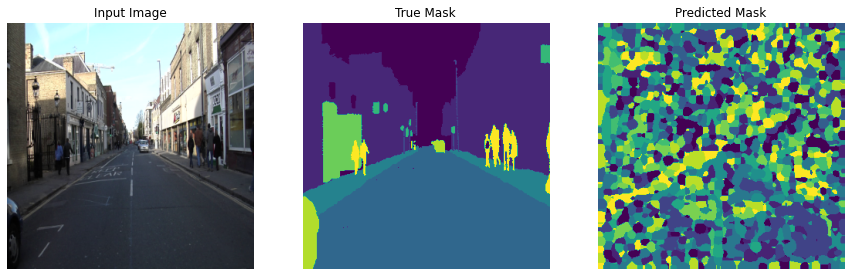

In [14]:
def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

def create_mask(pred_mask):
    
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

def show_predictions(dataset=None, num=1):
    output_model = model(sample_image[tf.newaxis, ...])
    # print(output_model.numpy())
    
    output_mask = create_mask(output_model)
    # print(sample_mask.shape)

    scce = tf.keras.losses.CategoricalCrossentropy()
    print("SparseCategoricalCrossentroy: " + str(scce(sample_mask, output_model[0]).numpy()))
    # print(iou_score(sample_mask, output_model[0]))
    print("Iou-Score: " + str(tasm.losses.iou_score(sample_mask[tf.newaxis, ...], output_model, class_weights=class_weights).numpy()))
    # print("Dice Loss: " + str(dice_loss(sample_mask, output_model[0]).numpy()))
    # print("Categorical Focal Loss: " + str(categorical_focal_loss(sample_mask, output_model[0]).numpy()))
    print("categorical Focal Dice Loss: " + str(categorical_focal_dice_loss(sample_mask[tf.newaxis, ...], output_model).numpy()))
    
    display([sample_image, tf.argmax(sample_mask, axis=-1)[..., tf.newaxis], output_mask]) # K.one_hot(K.squeeze(output_mask, axis=-1), 3)])
    
show_predictions()

# Training

## Training Procedure

**Train model with freezed backbone only on train data**

### Train model with freezed backbone only on train data

<p>Set Backbone trainable to False.</p>

In [15]:
for layer in model.layers:
    if "functional" in layer.name:
        layer.trainable = False

    print(layer.name + ": " + str(layer.trainable))

up_sampling2d: True
functional_1: False
convolution_bn_activation: True
convolution_bn_activation_1: True
pam__module: True
cam__module: True
convolution_bn_activation_5: True
convolution_bn_activation_6: True
dropout: True
dropout_1: True
dropout_2: True
convolution_bn_activation_7: True
convolution_bn_activation_8: True
convolution_bn_activation_9: True
concatenate_1: True
concatenate_2: True
convolution_bn_activation_10: True


In [20]:
if WWO_AUG:
    steps_per_epoch = np.floor(len(os.listdir(x_train_dir)) / BATCH_SIZE) * 2
else:
    steps_per_epoch = np.floor(len(os.listdir(x_train_dir)) / BATCH_SIZE)
tf.config.run_functions_eagerly(True)

@tf.function
def train_step(x, y):
    # Calculate the model's prediction and with it the loss and iou-score
    with tf.GradientTape() as tape:
        preds = model(x)
        loss = categorical_focal_dice_loss(y, preds)
        iou = iou_score(y, preds)
    
    # get the gradients dependent of the current loss
    grads = tape.gradient(loss, model.trainable_weights)
    # apply the gradients on the trainable model weights with the chosen optimizer
    opt.apply_gradients(zip(grads, model.trainable_weights))

    return loss, iou

@tf.function
def validation_step(x, y):
    # Calculate the model's prediction and with it the loss and iou-score
    preds = model(x)
    test_loss = categorical_focal_dice_loss(y, preds)
    test_iou = iou_score(y, preds)

    return test_loss, test_iou

TRAIN_LOSSES = []
TRAIN_IOU_SCORES = []
VAL_LOSSES = []
VAL_IOU_SCORES = []
best_iou_score = 0.0
for epoch in range(10):
    print("Epoch: {}".format(epoch))
    # initializes training losses and iou_scores lists for the epoch
    losses = []
    iou_scores = []
    for step, (batch) in enumerate(TrainSet):
        x, y = batch[0], batch[1]
        # run one training step for the current batch
        loss, iou = train_step(x, y)

        # Save current batch loss and iou-score
        losses.append(float(loss))
        iou_scores.append(float(iou))

        # Log epoch loss and iou-score if trained over whole dataset
        if step % (steps_per_epoch - 1) == 0 and step != 0:
            # Run now the validation
        
            # Repeat the training process for the validation set
            val_losses = []
            val_iou_scores = []
            for val_step, val_batch in enumerate(ValidationSet):
                x_val, y_val = val_batch[0], val_batch[1]
                # Just calculate the loss and iou-score for the current batch,
                # do not run a gradient step
                val_loss, val_iou_score = validation_step(x_val, y_val)

                val_losses.append(val_loss)
                val_iou_scores.append(val_iou_score)

                if val_step % 59 == 0 and val_step != 0:
                    print("Epoch:", epoch, "\tLoss:", np.round(sum(losses) / len(losses), 4), "\tIOU-Score:", np.round(sum(iou_scores) / len(iou_scores), 4), "\tVal_Loss:", np.round(sum(val_losses) / len(val_losses), 4), "\tVal_IOU-Score:", np.round(sum(val_iou_scores) / len(val_iou_scores), 4))
                    
                    # If iou score of current epoch is better than best iou score, save model and update best iou score
                    if sum(val_iou_scores) / len(val_iou_scores) > best_iou_score:
                        best_iou_score = sum(val_iou_scores) / len(val_iou_scores)
                        model.save_weights(MODEL_PATH)

                    break

            # Save the train and validation losses and iou scores for each epoch.
            TRAIN_LOSSES.append(sum(losses) / len(losses))
            TRAIN_IOU_SCORES.append(sum(iou_scores) / len(iou_scores))

            VAL_LOSSES.append(sum(val_losses) / len(val_losses))
            VAL_IOU_SCORES.append(sum(val_iou_scores) / len(val_iou_scores))
            
            break

Epoch: 0
Epoch: 0 	Loss: -0.2142 	IOU-Score: 0.2915 	Val_Loss: -0.1923 	Val_IOU-Score: 0.2907
Epoch: 1
Epoch: 1 	Loss: -0.5683 	IOU-Score: 0.3452 	Val_Loss: -0.2891 	Val_IOU-Score: 0.3205
Epoch: 2
Epoch: 2 	Loss: -0.6893 	IOU-Score: 0.3624 	Val_Loss: -0.3038 	Val_IOU-Score: 0.3219
Epoch: 3
Epoch: 3 	Loss: -0.7591 	IOU-Score: 0.3732 	Val_Loss: -0.4177 	Val_IOU-Score: 0.3309
Epoch: 4
Epoch: 4 	Loss: -0.7781 	IOU-Score: 0.3779 	Val_Loss: -0.5469 	Val_IOU-Score: 0.3394
Epoch: 5
Epoch: 5 	Loss: -0.816 	IOU-Score: 0.3809 	Val_Loss: -0.5737 	Val_IOU-Score: 0.3437
Epoch: 6
Epoch: 6 	Loss: -0.8577 	IOU-Score: 0.3844 	Val_Loss: -0.615 	Val_IOU-Score: 0.3522
Epoch: 7
Epoch: 7 	Loss: -0.9262 	IOU-Score: 0.3917 	Val_Loss: -0.6012 	Val_IOU-Score: 0.3521
Epoch: 8
Epoch: 8 	Loss: -0.9299 	IOU-Score: 0.3962 	Val_Loss: -0.6265 	Val_IOU-Score: 0.3558
Epoch: 9
Epoch: 9 	Loss: -0.9261 	IOU-Score: 0.3853 	Val_Loss: -0.658 	Val_IOU-Score: 0.3535


### Plot Training IoU Scores and Losses

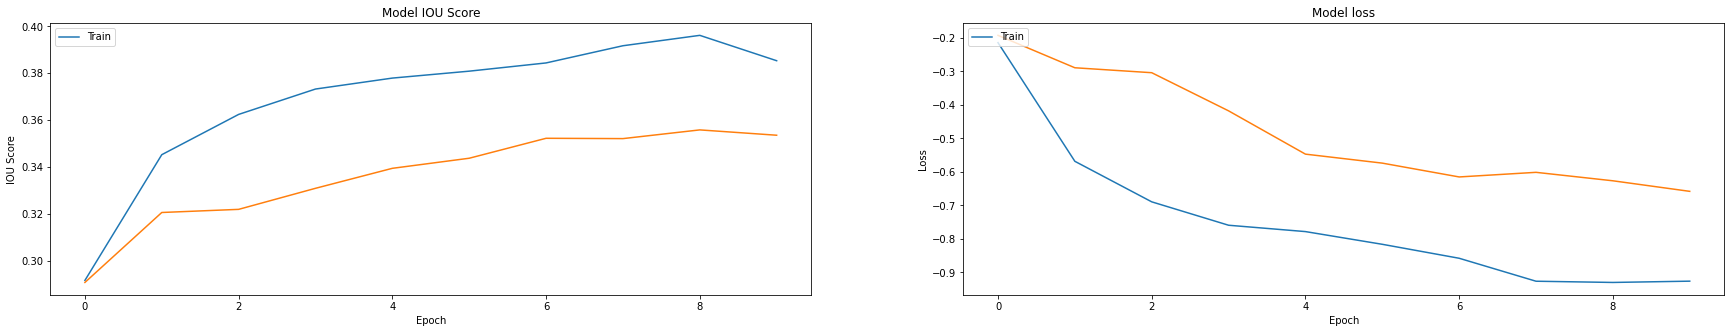

In [22]:
# Plot Training and Validation IOU Scores
plt.figure(figsize=(30, 5))
plt.subplot(121)
plt.plot(TRAIN_IOU_SCORES)
plt.plot(VAL_IOU_SCORES)
plt.title('Model IOU Score')
plt.ylabel('IOU Score')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper left')

# Plot Training and Validation Losses
plt.subplot(122)
plt.plot(TRAIN_LOSSES)
plt.plot(VAL_LOSSES)
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper left')
plt.show()

# Evaluation on Test Data

In [28]:
model.load_weights(MODEL_PATH)

test_losses = []
test_iou_scores = []
for test_step, test_batch in enumerate(TestSet):
    
    x_test, y_test = test_batch[0], test_batch[1]
    # Just calculate the loss and iou-score for the current batch,
    # do not run a gradient step
    test_loss, test_iou_score = validation_step(x_test, y_test)

    test_losses.append(val_loss)
    test_iou_scores.append(test_iou_score)
    if test_step % 100 == 0 and test_step != 0:
        break

test_loss = np.round(sum(test_losses) / len(test_losses))
test_iou_score = np.round(sum(test_iou_scores) / len(test_iou_scores))

print("Loss: {:.5}".format(test_loss))
print("IOU-Score: {:.4}".format(test_iou_score))

Loss: -1.0
IOU-Score: 0.0


## Visual Examples on Test Data

[18 60 51 53 57]
18


/usr/local/lib/python3.6/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3350: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "


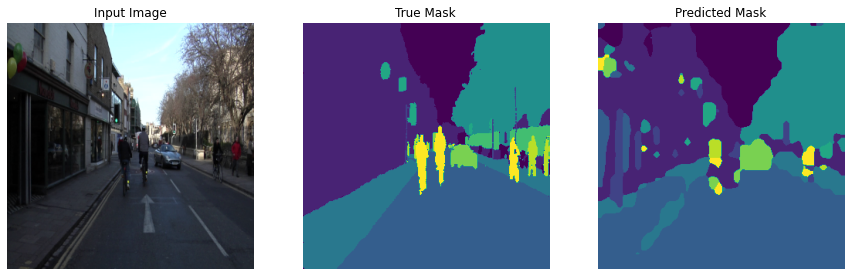

51


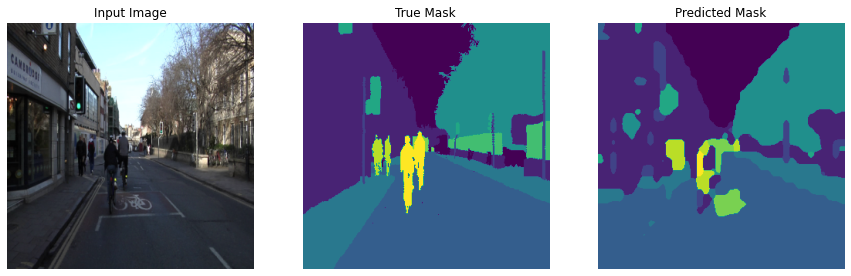

53


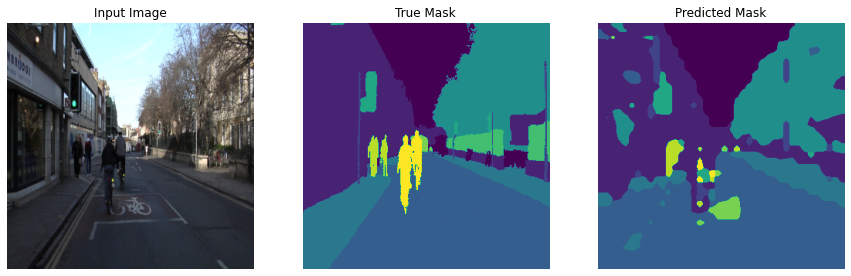

57


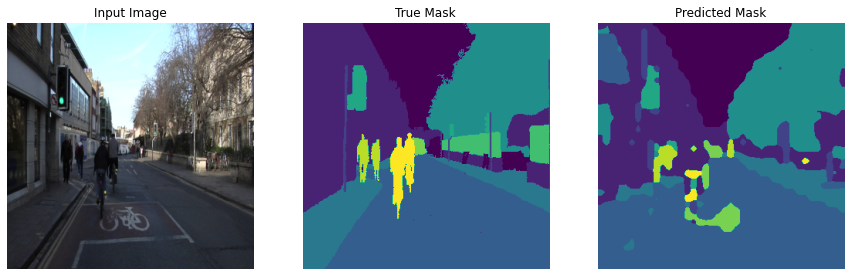

60


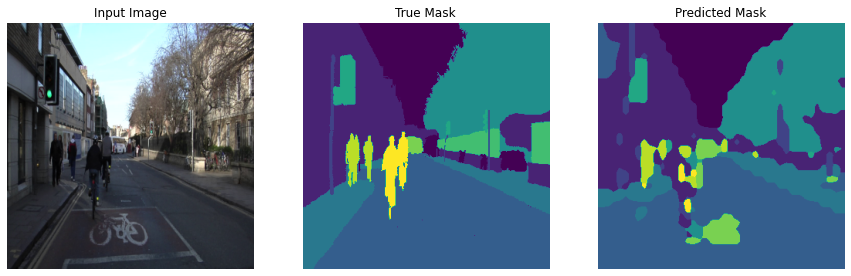

In [29]:
n = 5
ids = np.random.choice(np.arange(101), size=n,replace=False)
print(ids)

counter = 0
second_counter = 0
    
for i in TestSet:
    if counter in ids:
        print(counter)
        image, gt_mask = i

        output_model = model.predict(image)
        output_mask = create_mask(output_model)
    
        display([image[0], tf.argmax(gt_mask[0], axis=-1)[..., tf.newaxis], output_mask])

        second_counter += 1
    counter += 1
    if second_counter == n:
        break